In [1]:
import pandas as pd



df = pd.read_csv("spojeny.csv")
# Odstranenie nerelevantnych stlpcov
df_cleaned = df.drop(columns=['caseid', 'subjectid', 'casestart'])


In [2]:
# Odstranenie stlpcov s chybajucimi hodnotami viac ako 50%
threshold = 0.5
missing_ratio = df_cleaned.isnull().mean()
columns_to_drop = missing_ratio[missing_ratio > threshold].index
df_reduced = df_cleaned.drop(columns=columns_to_drop)
df_reduced

,caseend,anestart,aneend,opstart,opend,adm,dis,icu_days,death_inhosp,age,...,intraop_vecu,intraop_eph,intraop_phe,intraop_epi,intraop_ca,hypotenzia,case_duration,ane_duration,op_duration,hospital_stay
0,11542,-552,10848.0,1668,10368,-236220,627780,0,0,77.0,...,0,10,0,0,0,1,3.206111,2.860000,2.416667,10.0
1,20990,-778,20222.0,2522,17822,-201120,576480,1,0,74.0,...,0,50,0,0,0,1,5.830556,5.401111,4.250000,9.0
2,15770,477,14817.0,3177,14577,-154320,623280,3,0,52.0,...,0,0,0,0,0,1,4.380556,3.983333,3.166667,9.0
3,20992,-1743,21057.0,2457,19857,-220740,3580860,1,0,72.0,...,0,20,500,0,600,1,5.831111,5.365000,4.833333,44.0
4,31203,-220,31460.0,5360,30860,-208500,1519500,4,0,46.0,...,0,20,0,0,3300,1,8.667500,8.677778,7.083333,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3512,23242,-1883,23137.0,3037,22641,-224040,812760,0,0,37.0,...,0,10,0,0,300,0,6.456111,5.903889,5.445556,12.0
3513,20643,-544,20996.0,2396,19496,-225600,1675200,0,0,69.0,...,0,25,30,0,300,1,5.734167,5.681111,4.750000,22.0
3514,19451,-667,19133.0,3533,18233,-200460,836340,0,0,61.0,...,0,10,0,0,0,1,5.403056,5.129444,4.083333,12.0
3515,12025,-550,12830.0,1730,11030,-227760,377040,0,0,24.0,...,0,0,0,0,0,1,3.340278,3.411111,2.583333,7.0


In [3]:
import numpy as np

# Ciselne stlpce
numeric_cols = df_reduced.select_dtypes(include=[np.number]).columns


binary_cols = []
continuous_cols = []
# Binarne a kontinualne stlpce
for col in numeric_cols:
    unique_vals = df_reduced[col].dropna().unique()
    if set(unique_vals).issubset({0, 1}):
        binary_cols.append(col)
    else:
        continuous_cols.append(col)

In [4]:
df_imputed = df_reduced.copy()

# Nahradenie chybajucich hodnot binarnych stlpcov pomocou najcastejsej hodnoty
for col in binary_cols:
    mode_val = df_imputed[col].mode()[0]
    df_imputed[col] = df_imputed[col].fillna(df_imputed[col].mode()[0])

# Nahradenie chybajucich hodnot kontinualnych pomocou priemeru 
for col in continuous_cols:
    mean_val = df_imputed[col].mean()
    df_imputed[col] = df_imputed[col].fillna(df_imputed[col].mean())

# Nahradenie chybajucich hodnot kategorii pomocou modu
categorical_cols = df_imputed.select_dtypes(include='object').columns
for col in categorical_cols:
    mode_val = df_imputed[col].mode()[0]
    df_imputed[col] = df_imputed[col].fillna(df_imputed[col].mode()[0])

df_imputed.to_csv("df_imputed.csv")


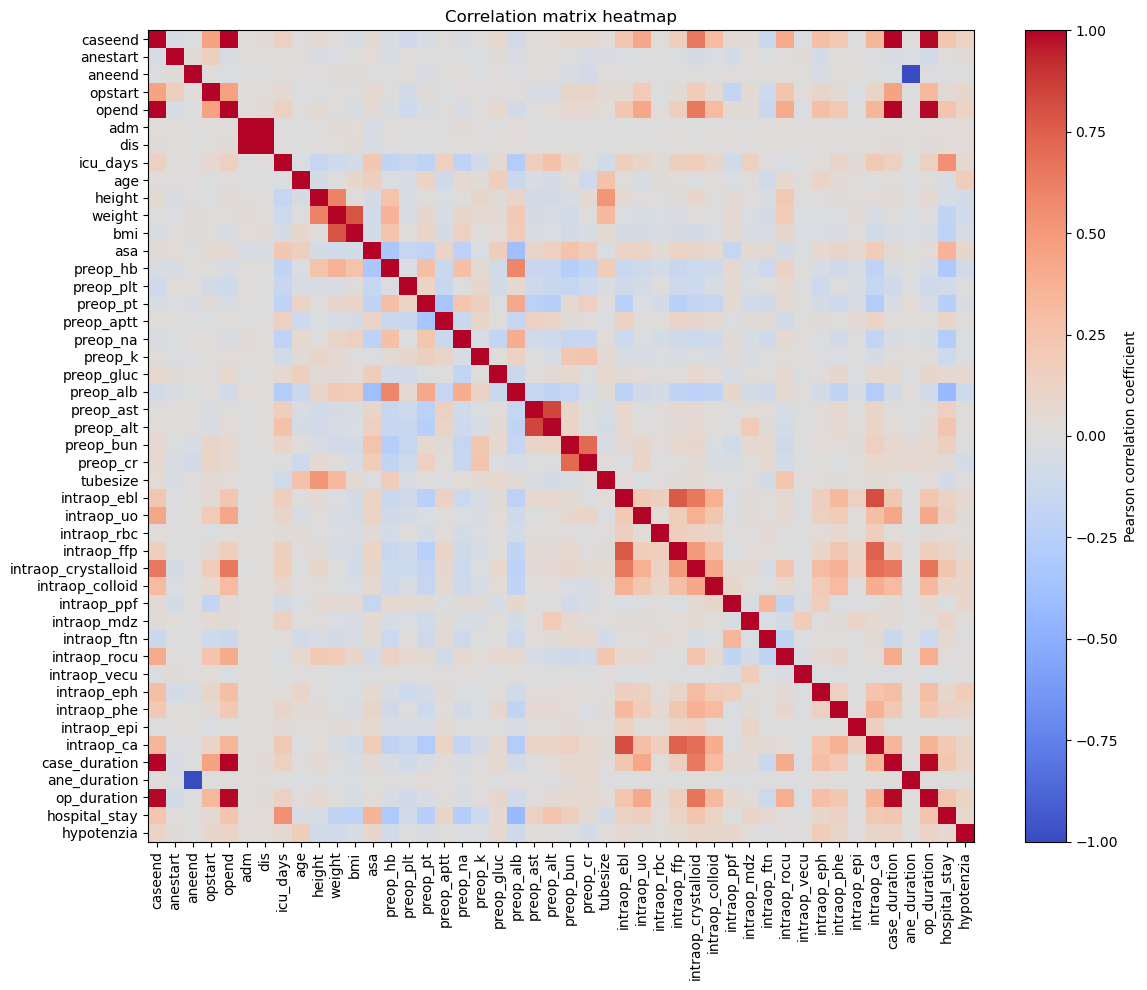

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt


corr_matrix = df_imputed[continuous_cols + ['hypotenzia']].corr()

plt.figure(figsize=(12, 10))
plt.imshow(corr_matrix, aspect='auto', cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(label='Pearson correlation coefficient')
plt.xticks(range(len(corr_matrix)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix)), corr_matrix.columns)
plt.title('Correlation matrix heatmap')
plt.tight_layout()
plt.show()

corr_matrix.to_excel("corrmatrix.xlsx")


In [6]:
# chi2_df
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency, chi2


df_imputed = pd.read_csv("df_imputed.csv")

# Konverzia stlpca hypotenzia
if df_imputed["hypotenzia"].dtype != 'object':
    df_imputed["hypotenzia"] = df_imputed["hypotenzia"].astype(str)

# Zoznam kategorii
categorical_columns = df_imputed.select_dtypes(include=['object', 'category']).columns.tolist()
if "hypotenzia" not in categorical_columns:
    categorical_columns.append("hypotenzia")

alpha = 0.05
results = []

# Iteracia cez dvojice 
for i in range(len(categorical_columns)):
    for j in range(i + 1, len(categorical_columns)):
        col1, col2 = categorical_columns[i], categorical_columns[j]
        table = pd.crosstab(df_imputed[col1], df_imputed[col2])
        
        # Ak ma tabulka menej ako 2 riadky alebo stlpce, preskocime ju
        if table.shape[0] < 2 or table.shape[1] < 2:
            continue

        chi2_stat, p, dof, expected = chi2_contingency(table, correction=False)
        crit = chi2.ppf(1 - alpha, dof) if dof > 0 else np.nan
        significant = chi2_stat > crit

        results.append([
            col1, col2, round(chi2_stat, 4), round(crit, 4) if not np.isnan(crit) else np.nan,
            round(p, 4), dof, "Yes" if significant else "No"
        ])

# Vytvorenie DataFrame 
chi2_df = pd.DataFrame(results, columns=[
    "Variable 1", "Variable 2", "Chi-square Statistic", "Critical Value",
    "p-value", "Degrees of Freedom", "Significant"
])

# chi2_df.to_excel("chi_square_results_with_hypotenzia3.xlsx", index=False)

print(chi2_df)


    Variable 1  Variable 2  Chi-square Statistic  Critical Value  p-value  \
0          sex  department              293.1807          7.8147   0.0000   
1          sex      optype              132.3252         18.3070   0.0000   
2          sex          dx             1231.7513        777.2733   0.0000   
3          sex      opname              608.3816        229.6632   0.0000   
4          sex    approach               22.9849          5.9915   0.0000   
..         ...         ...                   ...             ...      ...   
100     airway      aline1               45.4229         26.2962   0.0001   
101     airway  hypotenzia                1.7615          5.9915   0.4145   
102        iv1      aline1              301.0038        101.8795   0.0000   
103        iv1  hypotenzia               12.1166         18.3070   0.2773   
104     aline1  hypotenzia                4.6683         15.5073   0.7924   

     Degrees of Freedom Significant  
0                     3         Yes  

In [7]:
# VYBER ATRIBUTOV

chi_results = []

for col in categorical_cols:
    if col == 'hypotenzia':
        continue
    table = pd.crosstab(df_imputed[col], df_imputed['hypotenzia'])
    
    if table.shape[0] < 2 or table.shape[1] < 2:
        continue 
    
    chi2_stat, p, dof, expected = chi2_contingency(table, correction=False)
    
    chi_results.append({
        'Feature': col,
        'Chi2 Stat': round(chi2_stat, 3),
        'p-value': round(p, 3),
        'Degrees of Freedom': dof,
        'Significant': p < 0.05
    })

chi_df = pd.DataFrame(chi_results)
significant_chi = chi_df[chi_df['Significant'] == True].copy()
significant_chi




,Feature,Chi2 Stat,p-value,Degrees of Freedom,Significant
2,optype,62.000,0.000,10,True
3,dx,849.621,0.000,714,True
4,opname,354.074,0.000,196,True
7,ane_type,10.705,0.005,2,True


In [8]:
# --- KORELACNA ANALYZA  ---
# Vypočitame Pearsonovu korelačnú maticu
corr_matrix = df_imputed[numeric_cols].corr(method='pearson')

# Ulozenie silno korelovanych dvojic
high_corr_pairs = []
threshold = 0.8

for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        col1 = corr_matrix.columns[i]
        col2 = corr_matrix.columns[j]
        corr_value = corr_matrix.iloc[i, j]
        if abs(corr_value) > threshold:
            high_corr_pairs.append((col1, col2, round(corr_value, 3)))

high_corr_pairs_df = pd.DataFrame(high_corr_pairs, columns=["Feature 1", "Feature 2", "Correlation"])
high_corr_pairs_df


,Feature 1,Feature 2,Correlation
0,caseend,opend,0.999
1,caseend,case_duration,1.000
2,caseend,op_duration,0.989
3,aneend,ane_duration,-1.000
4,opend,case_duration,0.999
5,opend,op_duration,0.991
6,adm,dis,1.000
7,preop_ast,preop_alt,0.841
8,intraop_ebl,intraop_ca,0.820
9,case_duration,op_duration,0.989


In [9]:
# --- 3. VYBER ATRIBUTOV z korelacne redundantnych dvojic ---

# Inicializujeme mnoziny pre vyber
selected_numerical = set(numeric_cols)
removed_due_to_corr = set()

# Iterativne prechadzame cez silne korelovane dvojice
for feat1, feat2, corr_val in high_corr_pairs:
    if feat1 in selected_numerical and feat2 in selected_numerical:
        # Odstranime druhy atribut z dvojice
        selected_numerical.remove(feat2)
        removed_due_to_corr.add(feat2)

# Finalny vyber 
selected_numerical = list(selected_numerical)


selected_numerical = sorted(selected_numerical)
removed_due_to_corr = sorted(removed_due_to_corr)

selected_numerical[:10], removed_due_to_corr[:10] 



(['adm',
  'age',
  'aneend',
  'anestart',
  'asa',
  'bmi',
  'caseend',
  'death_inhosp',
  'emop',
  'height'],
 ['ane_duration',
  'case_duration',
  'dis',
  'intraop_ca',
  'op_duration',
  'opend',
  'preop_alt'])

In [10]:
# Kategorialne atributy z chi testu
selected_categorical = ['optype', 'dx', 'opname', 'ane_type']

# Finalny zoznam 
final_features = selected_numerical + selected_categorical 

# Vytvorenie DataFrame 
df_selected = df_imputed[final_features].copy()

df_selected.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3517 entries, 0 to 3516
Data columns (total 47 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   adm                  3517 non-null   int64  
 1   age                  3517 non-null   float64
 2   aneend               3517 non-null   float64
 3   anestart             3517 non-null   int64  
 4   asa                  3517 non-null   float64
 5   bmi                  3517 non-null   float64
 6   caseend              3517 non-null   int64  
 7   death_inhosp         3517 non-null   int64  
 8   emop                 3517 non-null   int64  
 9   height               3517 non-null   float64
 10  hospital_stay        3517 non-null   float64
 11  hypotenzia           3517 non-null   object 
 12  icu_days             3517 non-null   int64  
 13  intraop_colloid      3517 non-null   int64  
 14  intraop_crystalloid  3517 non-null   float64
 15  intraop_ebl          3517 non-null   f

In [11]:

import pandas as pd
from sklearn.preprocessing import LabelEncoder

df=df_selected

# Zistenie poctu uikatnych hodnot
object_columns = df.select_dtypes(include=['object']).columns.tolist()
if 'hypotenzia' in object_columns:
    object_columns.remove('hypotenzia')
for col in object_columns:
    print(f"{col}: {df[col].nunique()} unique values")

# Label encoding (pre ordinalne a/ vysoko kardinalitne atribúty)
label_enc_cols = ['dx', 'opname']
# One-hot encoding (pre nominalne atributy s nizkou kardinalitou)
one_hot_cols = [col for col in object_columns if col not in label_enc_cols]



# Aplikujeme label encoding
le_dict = {}  # slovnik pre uloženie encoderov
for col in label_enc_cols:
    le = LabelEncoder()
    df[col + '_le'] = le.fit_transform(df[col])
    le_dict[col] = le

# Aplikujeme one-hot encoding pomocou pd.get_dummies
df_onehot = pd.get_dummies(df[one_hot_cols], prefix=one_hot_cols)

# finalny dataset:
df_encoded = df.drop(columns=one_hot_cols + label_enc_cols).join(df_onehot)

df_encoded.to_csv("df_encoded.csv")


optype: 11 unique values
dx: 715 unique values
opname: 197 unique values
ane_type: 3 unique values


In [12]:
from sklearn.preprocessing import MinMaxScaler

X = df_encoded.drop(columns=['hypotenzia'])
y = df_encoded['hypotenzia']

# numericke atributy
num_cols = X.select_dtypes(include='number').columns.tolist()

scaler = MinMaxScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

In [13]:
from sklearn.model_selection import train_test_split

X = df_encoded.drop(columns=['hypotenzia'])
y = df_encoded['hypotenzia']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
df_encoded['hypotenzia']

0       1
1       1
2       1
3       1
4       1
       ..
3512    0
3513    1
3514    1
3515    1
3516    1
Name: hypotenzia, Length: 3517, dtype: object

In [14]:
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))


hypotenzia
1    0.825098
0    0.174902
Name: proportion, dtype: float64
hypotenzia
1    0.825284
0    0.174716
Name: proportion, dtype: float64
